**Выполнил**: Копин Борис

**Затрачено времени**: 1ч 05м

# Part 1

### Test 1
в одну строку на Python записать код подсчёта количества "счастливых" билетов с номерами из четырёх десятичных цифр "счастливый билет" это у которого сумма в данном случае двух первых цифр равна сумме двух последних цифр

In [37]:
sum(int(a) + int(b) == int(c) + int(d) for a, b, c, d in ('{0:04d}'.format(i) for i in range(10000)))

670

In [38]:
list(a+b+c+d for a, b, c, d in ('{0:04d}'.format(i) for i in range(10000)) if int(a) + int(b) == int(c) + int(d))[:10]

['0000',
 '0101',
 '0110',
 '0202',
 '0211',
 '0220',
 '0303',
 '0312',
 '0321',
 '0330']

# Part 2

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline

In [41]:
df = pd.read_csv("data.csv")
df.head()

,user,ts,score_diff,event
0,user_0,2016-07-02 08:36:46.019558,0,view_category
1,user_3,2016-07-05 19:18:49.966119,2,view_item
2,user_0,2016-07-05 03:31:17.310296,2,buy
3,user_5,2016-07-03 16:20:23.389334,0,view_category
4,user_4,2016-07-04 17:19:12.063729,1,login


In [42]:
df.ts = pd.to_datetime(df.ts)
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)

### Test 2

In [44]:
# Начертить куммулятивную сумму score от времени для каждого пользователя user_X на одном графике
# пользоваться seaborn или matplotlib
# поместить график inline в notebook

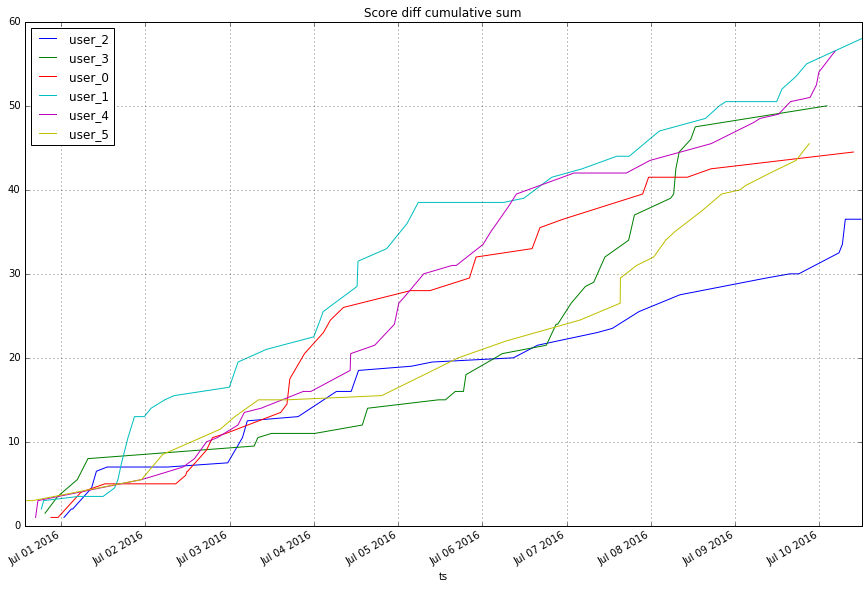

In [45]:
plt.figure(figsize=(15, 10))
for user_name, idx in df.groupby("user").groups.iteritems():
    df.loc[idx].score_diff.cumsum().plot(title='Score diff cumulative sum',
                                         label=user_name,
                                         legend=True,
                                         grid=True)

### Test 3

In [46]:
# Построить датасет из исходного с дополнительными признаками:
# events_before_this -- количество записей для данного пользователя в исходном датасете до (по времени) данной записи 
# events_after_this -- количество записей для данного пользователя в исходном датасете после данной записи 
# converted -- 1 если событие buy уже произошло (по времени раньше времени данной записи), 0 -- если не произошло
# will_convert -- 1 если событие buy произойдёт позже (т.е. ещё встретится в датасете), 0 -- если не встретится больше
#

In [47]:
import numpy as np
import datetime as dt

# By Feedforward

In [48]:
def compute_cumulative_features(frame):
    state = {
        "user": '',
        "events_before_this": 0,
        "is_buy_appeared": False,
    }
    
    features = []
    for _, row in frame.iterrows():
        if state["user"] != row["user"]:
            state["user"] = row["user"]
            state["events_before_this"] = -1
            state["is_buy_appeared"] = False
            
        state["events_before_this"] += 1

        features.append((state["events_before_this"], state["is_buy_appeared"]))
        
        if row["event"] == "buy" and not state["is_buy_appeared"]:
            state["is_buy_appeared"] = True

    return features


def compute_by_feedforward(frame):
    ascending_features = compute_cumulative_features(frame)
    ascending_features_df = pd.DataFrame(ascending_features,
                                         columns=["events_before_this", "converted"])

    descending_features = compute_cumulative_features(frame[::-1])
    descending_features_df = pd.DataFrame(descending_features[::-1],
                                          columns=["events_after_this", "will_convert"])

    result = pd.concat([frame, ascending_features_df, descending_features_df], axis=1)

# By Groupby

In [49]:
def feature_extraction(group):
    group["events_before_this"] = range(len(group))
    group["events_after_this"] = range(len(group))[::-1]
    
    buy_event_cumsum = (group["event"] == "buy").cumsum()
    group["converted"] = [False] + buy_event_cumsum.astype(bool).tolist()[:-1]
    group["will_convert"] = (buy_event_cumsum.max() - buy_event_cumsum).astype(bool)
    
    return group

def compute_by_groupby(frame):
    new_frame = frame.groupby("user").apply(feature_extraction)
    return new_frame

# Testing

In [50]:
def generate_new_df(initial_df, samples=100000):
    gen_df = initial_df.sample(n=samples, replace=True)
    gen_df.loc[:, "ts"] = gen_df["ts"].apply(
        lambda t: t + dt.timedelta(minutes=np.random.randint(-100, 100),
                                   seconds=np.random.randint(-1000, 1000))
    )
    gen_df.loc[:, "user"] = gen_df["user"].apply(lambda x: "user_%d" % np.random.randint(samples / 40))

    gen_df = gen_df.sort_values(['user', 'ts'], ascending=[True, True], kind="heapsort")
    gen_df = gen_df.reset_index(drop=True)
    
    return gen_df

In [51]:
initial_df = df.reset_index(drop=False)\
               .sort_values(['user', 'ts'], ascending=[True, True], kind="heapsort")\
               .reset_index(drop=True)

In [52]:
small_df = initial_df
big_df = generate_new_df(initial_df, samples=100000)

In [53]:
%timeit -r5 result = compute_by_groupby(small_df);

10 loops, best of 5: 21.4 ms per loop


In [54]:
%timeit -r5 result = compute_by_feedforward(small_df);

10 loops, best of 5: 41.3 ms per loop


In [55]:
%timeit -r5 result = compute_by_groupby(big_df);

1 loops, best of 5: 7.1 s per loop


In [56]:
%timeit -r5 result = compute_by_feedforward(big_df);

1 loops, best of 5: 20.1 s per loop
